In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
#import matplotlib


import matplotlib.pylab as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

import tensorflow_hub as hub
import numpy as np
import pandas as pd
import argparse
import cv2

In [2]:
!pip install q keras==2.3.0
import keras
keras.__version__

     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


Using TensorFlow backend.


'2.3.0'

In [0]:
((trainX, _), (testX, _)) = mnist.load_data()
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

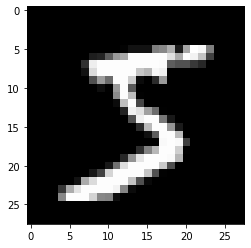

In [13]:
X = trainX[0].reshape([28, 28]);
plt.gray()
plt.imshow(X)
#Actually displaying the plot if you are not in interactive mode
plt.show()

In [0]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [0]:
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


In [0]:
EPOCHS = 1
BS = 32

H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

1875/1875 [==============================] - 135s 72ms/step - loss: 0.0194 - val_loss: 0.0106


In [0]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [0]:
decoded = autoencoder.predict(testX)
outputs = None
#samples = [1 31 141 234]
# loop over our number of output samples
for i in range(0, 10):
	# grab the original image and reconstructed image
	original = (testX[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
  
cv2.imwrite("output.png", outputs)

ERROR! Session/line number was not unique in database. History logging moved to new session 60


True

So far, we built a model for Auto Encoder using CNN. Below section is to -
a. Add a noise in the input image
b. train a CNN auto encoder model on top of these train images
c. Aim is to remove these noise from input image and predict noise free image

In [0]:
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

In [0]:
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


In [0]:
EPOCHS = 1
BS = 32
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)

1875/1875 [==============================] - 140s 75ms/step - loss: 0.0279 - val_loss: 0.0193


In [0]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot1.png")

In [0]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testXNoisy)
outputs = None

# loop over our number of output samples
for i in range(0, 10):
	# grab the original image and reconstructed image
	original = (testXNoisy[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# save the outputs image to disk
cv2.imwrite("output1.png", outputs)

[INFO] making predictions...


True